## General preparation

In [1]:
import pandas as pd
pd.set_option('display.width', 2000)

import matplotlib.pyplot as plt

# The Vectorizer will be used transform the different corpus into bits that can be understood from the algorithm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

import sys
import numpy as np

In [2]:
# 2019-10-29
# Later on this month I found out how - despite the limited dataset - there are still elements
# of imprecision around the clusterisation
# I therefore decided to update the code using a tokenizer

## Uncomment and Execute only the first time
# !{sys.executable} -m pip install nltk
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
# This is the a word tokenizer later user with the TfidfVectorizer 
import string

def word_tokenizer(text, stem=True):
    #tokenizes and stems the text
    tokens = word_tokenize(text.lower())
    tokens = list(filter(lambda token: token not in string.punctuation, tokens))

    if stem==True:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
    return tokens

In [199]:
# Create an array of strings I want to vectorize and cluster
# Strings have been created on purpose to be very similar, with minor exception to understand the capacity 
# of the algorithm to assign to the "correct" cluster.
corpus = [
    'The car is driven on the road.',
    'The truck is driven on the highway.',
    'The train run on the tracks.',
    'The bycicle is run on the pavement.',
    'The flight is conducted in the air.',
    'The baloon is conducted in the air.',
    'The bird is flying in the air.',
    'The man is walking in the street.',
    'The pedestrian is crossing the zebra.',
    'The pilot flights the plane].',
    'On the route, the car is driven.',
    'On the road, the truck is moved.',
    'The train is running on the tracks.',
    'The bike is running on the pavement.',
    'The flight takes place in the sky.',
    'Birds don''t fly when is dark',
    'The baloon is in the water.',
    'The bird flies in the sky.',
    'In the road, the guy walks.',
    'The pedestrian is passing through the zebra.',
    'The pilot is flying the plane.',    
    'This is a Japanese doll.',
    'I really want to go to work, but I am too sick to drive.',
    'Christmas is coming.',
    'With the daylight saving time turned off it''s getting dark soon.',
    'The body fat may compensates for the loss of nutrients.',
    'Mary plays the piano.',
    'She always speaks to him in a loud voice.',
    'Wow, does that work?',
    'I don''t like walking when it is dark',
    'Last Friday in three week’s time I saw a spotted striped blue worm shake hands with a legless lizard.',
    'My Mum tries to be cool by saying that she likes all the same things that I do.',
    'Mummy is saying that she loves me being a pilot when in reality she is scared all the time I take off.',    
    'Where do random thoughts come from?',
    'A glittering gem is not enough.',
    'We need to rent a room for our party.',
    'A purple pig and a green donkey flew a kite in the middle of the night and ended up sunburnt.',
    'If I don’t like something, I’ll stay away from it.',
    'The body may perhaps compensates for the loss of a true metaphysics.',
    'Don''t step on the broken glass.',
    'It was getting dark, and we weren''t there yet.', 
    'Playing an instrument like the guitar takes out the stress from my day.'
]

### Some useful routines for this exerice

In [46]:
def getKeywordsFromVector(vocabulary, vector):
    keyws = []
    
    for index, i in enumerate(X):
        ary = []
        for i in vector[index].indices:
            ary.append(vocabulary[i])
        keyws.append(ary)
    
    return keyws

def getKeywsIndexFromVocab(vocabulary, keywToFind):
    # This routine may be not very efficient, 
    # but it is used for debugging purposes only
    return dict(map(reversed, vocabulary.items())).get(keywToFind)

# Useful for understanding how the vectorize process works
#keys = getKeywordsFromVector(keywsVoc, X)
#keys

# print(getKeywsIndexFromVocab(keywsVoc, 'soon'))

## TF-IDF Vectorizer

In [199]:
# Create a vector. Key things here are:
# - the use of the max_df param to exclude terms that are used too often
# - the stop_words to eliminate things like prepositions and article that are not normally playing a role
#   Interestingly enough, connected to my industry, Google recently rolled up a new algorithm called Bert 
#   with the aim to better understand the meaning of stop words in the context
#
#   Here it would be cool to understand how Tensorflow and the open-source project can be used for Clustering?
#   https://github.com/google-research/bert
#
# - ngram_range to create vectors formed ngrams.
#   Note: I believed the usage of this technique would have increase the understanding of the documents within the corpus
#         but this is not the case as the keywords later found relevant for the matching and the elements paired are
#         ultimately inconsitent.
#   An example of what bi-gram is can be seen at: https://onlinetexttools.com/generate-text-bigrams
vectorizer = TfidfVectorizer(analyzer='word', 
                             max_df=0.8, 
                             max_features=50000, 
                             #stop_words="english", 
                             lowercase=True, 
                             #ngram_range=(2,3),
                             tokenizer=word_tokenizer)

X = vectorizer.fit_transform(corpus)

# Creating a keywords vocabulary flipping the order of the index with the one of the keyword.
# I later use this to:
# - compute the overlapping terms and - somehow - the confidence I can have in the trained model
# - print the results of the clusterisation
keywsVoc = {key: value for (value, key) in vectorizer.vocabulary_.items()}

## Using the Elbow method to finds the "right" numbers of clusters to use

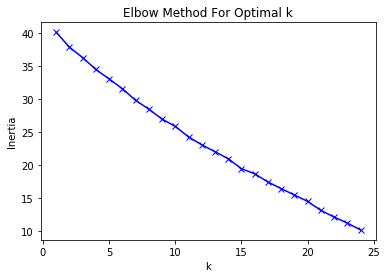

In [15]:
# The kmeans inertia should be the right approach
inertia = []
K = range(1,25)
for cluster in K:
    km = KMeans(n_clusters=cluster, random_state=1021)
    km = km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# However the plot below is not necessary all clear, certainly not when there is not an "elbow"

In [ ]:
# After a research, I have identified Yellowbrick, a wrapper for the Scikit-Learn API 
# that facilitate the visualization of several things including Elbow and Silhouette

# Install the library. This can be achieved from Jupyter too provided the right method is used
# no harm in executing. If the library is installed already, Jupyter will prompt a "requirements are satisfied" message.
import sys
!{sys.executable} -m pip install yellowbrick

/usr/local/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


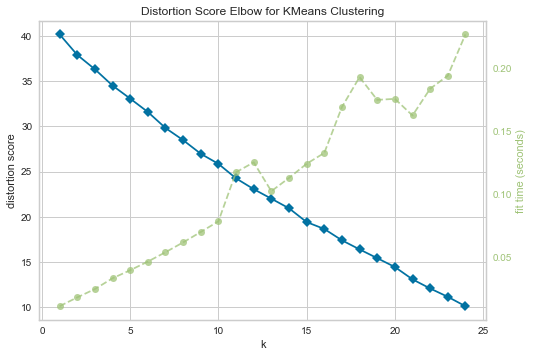

In [16]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=1021)
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(km, k=K)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

# Any error in identifying the elbow means that the right number of clusters was not found and
# perhaps more items to train the classifier are required, or different fine tunes.

## TfidfVectorizer

In [202]:
# Execute the clusterization
# - I specify eithe the right number of clusters found above OR
# - an hypothetical number I believe to be correct
num_clusters = 11
kmean = KMeans(n_clusters=num_clusters, random_state=1021)
%time clusters = kmean.fit_predict(X) 
#kmean.fit(X)

CPU times: user 111 ms, sys: 2.72 ms, total: 113 ms
Wall time: 113 ms


In [18]:
data = pd.DataFrame()
data['document'] = corpus

# Get a list of keywords that matched for each document in my corpus
data['Keywords'] = getKeywordsFromVector(keywsVoc, X) 
data['Kmeans cluster'] = clusters #kmean.labels_.tolist()

In [52]:
data

,document,Keywords,Kmeans cluster
0,The car is driven on the road.,"[road, driven, car]",3
1,The truck is driven on the highway.,"[highway, truck, driven]",3
2,The train run on the tracks.,"[track, run, train]",2
3,The bycicle is run on the pavement.,"[pavement, bycicl, run]",2
4,The flight is conducted in the air.,"[air, conduct, flight]",10
5,The baloon is conducted in the air.,"[baloon, air, conduct]",10
6,The bird is flying in the air.,"[fli, bird, air]",4
7,The man is walking in the street.,"[street, walk, man]",1
8,The pedestrian is crossing the zebra.,"[zebra, cross, pedestrian]",8
9,The pilot flights the plane].,"[plane, pilot, flight]",5


In [ ]:
###
### This is an experiment on how to intercept the data in the cluster
### It's not a functional part of this example
###
cluster_0 = np.where(clusters==0)
print(cluster_0)

# cluster_0 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
X_cluster_0 = X[cluster_0]
print(X_cluster_0)

In [ ]:
###
### This is an experiment not functional to this example
###
### The distance metrics
from scipy.spatial.distance import euclidean

distance = euclidean(X_cluster_0[0].toarray(), kmean.cluster_centers_[0])
print(distance)

In [203]:
def printClusters(vocabulary, clusterNum, centroids, featureColumnName):
    print("Top terms per cluster:")
    print()
    
    order_centroids = centroids.argsort()[:, ::-1] 
    
    for i in range(clusterNum):
        print("Cluster %d words:" % i)
        
        #print(np.flatnonzero(centroids[i]))
        vocabIdx = np.flatnonzero(centroids[i])
        avg = np.mean(centroids[i][vocabIdx])
        nonzero = centroids[i][vocabIdx]
        
        tbp = np.where(nonzero>avg)[0]
        #print(vocabIdx[tbp])
        #print(nonzero[tbp])
        
        print(f"{' Keyword':<25} {'Value':<10}") 
        print("-"*35)
        for index, z in enumerate(vocabIdx[tbp]):
            print(f" {vocabulary.get(z):<25}{nonzero[tbp][index]:<10{3.4}}")    

        print("")

        print("Cluster %d titles:" % i)
        for index, title in enumerate(data.document[data[featureColumnName]==i].values.tolist()):
            end = "\n" if index < len(data.document[data[featureColumnName]==i].values.tolist())-1 else ""
            print(' %s' % title, end=end)

        print("\n"*2) #add carriage return
            
#sort cluster centers by proximity to centroid
#order_centroids = kmean.cluster_centers_#.argsort()[:, ::-1] 
#num_clusters = 6
printClusters(keywsVoc, num_clusters, kmean.cluster_centers_, 'Kmeans cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 baloon                   0.1115                                                                                                 
 doll                     0.1179                                                                                                 
 enough                   0.09623                                                                                                
 gem                      0.09623                                                                                                
 glitter                  0.09623                                                                                                
 japanes                  0.1179                                                                                                 
 mari                     0.09941                                                                         

### Find the duplicate elements in the array

In [206]:
import numpy as np
from collections import Counter

# The Numpy nonzero returns a data structure containins two indices: 0, with the position of the cluster, 1 with the term's index
a = np.nonzero(kmean.cluster_centers_)
dup = [item for item, count in Counter(a[1]).items() if count > 1]
# print(dup)
# print(a)

# Identify the duplicated keywords and in which cluster the duplication occurred
[[keywsVoc[d], a[0][index]] for d in dup for index, item in list(enumerate(a[1])) if item == d]

[['baloon', 0],
 ['baloon', 10],
 ['play', 0],
 ['play', 1],
 ['dark', 1],
 ['dark', 4],
 ['dont', 1],
 ['dont', 4],
 ['road', 1],
 ['road', 3],
 ['say', 1],
 ['say', 5],
 ['take', 1],
 ['take', 5],
 ['take', 10],
 ['time', 1],
 ['time', 5],
 ['time', 8],
 ['’', 1],
 ['’', 8],
 ['air', 4],
 ['air', 10],
 ['fli', 4],
 ['fli', 5],
 ['sky', 4],
 ['sky', 10],
 ['flight', 5],
 ['flight', 10]]

## Kmode

In [ ]:
from kmodes.kmodes import KModes

# #random categorical data
# data = np.random.choice(20, (100, 10))

kmod_clust_num = 6
kmod = KModes(n_clusters=kmod_clust_num, init='CAO', n_init=3)#, verbose=1)

clusters1 = kmod.fit_predict(X.toarray())

# Print the cluster centroids
# print(km.cluster_centroids_)

# Assign the cluser labels back to the dataframe
data['KMode cluster'] = kmod.labels_.tolist()

In [ ]:
printClusters(keywsVoc, kmod_clust_num, kmod.cluster_centroids_, 'KMode cluster')

### Conclusions
Kmode doesn't seem to suit well for text classification. Kmode categorical clustering operates better when there are multiple features to be clustered.

## Gensim Corpora

In [183]:
from gensim import corpora
from gensim.matutils import corpus2csc
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

# remove common words and tokenize
texts = [
    word_tokenizer(item, False)
    for item in corpus
]

# # remove words that appear only once
# frequency = defaultdict(int)
# for text in texts:
#     for token in text:
#         frequency[token] += 1

# texts = [
#     [token for token in text if frequency[token] > 1]
#     for text in texts
# ]

dictionary = corpora.Dictionary(texts)
new_corpus = [dictionary.doc2bow(text) for text in texts]

from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(new_corpus)
corpus_tfidf = tfidf[new_corpus]

from gensim import matutils
X = corpus2csc(corpus_tfidf).transpose()

# Prepare a keyword dictionary in the format expceted by my routine
flat_list = [item for sublist in texts for item in sublist]
indexes = [i for block in texts for i in dictionary.doc2idx(block)]
corporaKeywsVoc = dict(zip(indexes, flat_list))

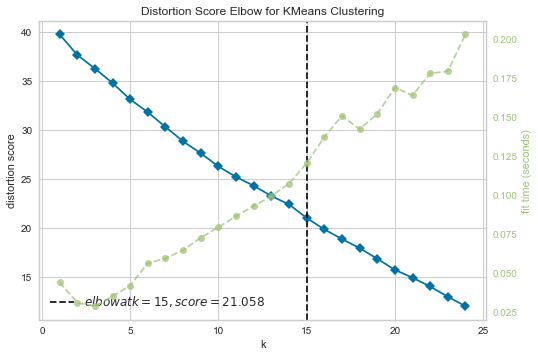

In [184]:
# Plot the graph to undestand the right number of clusters
visualizer = KElbowVisualizer(km, k=K)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [185]:
num_clusters = 15

from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=num_clusters, random_state=1021)
clusters = kmean.fit_predict(X) 

# Assign the cluser labels back to the dataframe
data['Gensim Corpora cluster'] = clusters

# print(X.shape)
# print(len(corpus))
# print(len(clusters))
# print(clusters)

In [186]:
data

,document,Keywords,Kmeans cluster,Gensim Corpora cluster
0,The car is driven on the road.,"[road, driven, car]",3,2
1,The truck is driven on the highway.,"[highway, truck, driven]",3,2
2,The train run on the tracks.,"[track, run, train]",2,5
3,The bycicle is run on the pavement.,"[pavement, bycicl, run]",2,5
4,The flight is conducted in the air.,"[air, conduct, flight]",10,1
5,The baloon is conducted in the air.,"[baloon, air, conduct]",10,1
6,The bird is flying in the air.,"[fli, bird, air]",4,1
7,The man is walking in the street.,"[street, walk, man]",1,3
8,The pedestrian is crossing the zebra.,"[zebra, cross, pedestrian]",8,7
9,The pilot flights the plane].,"[plane, pilot, flight]",5,4


In [187]:
printClusters(corporaKeywsVoc, num_clusters, kmean.cluster_centers_, 'Gensim Corpora cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 body                     0.3259                                                                                                 
 compensates              0.3259                                                                                                 
 for                      0.2825                                                                                                 
 loss                     0.3259                                                                                                 
 may                      0.3259                                                                                                 
 of                       0.2825                                                                                                 

Cluster 0 titles:
 The body fat may compensates for the loss of nutrients.
 The body may perhaps compensa

### Conclusions

Gensim Corpora so far seems to be the best approach to cluster documents in a corpus.

# Doc2Vec Implementation

In [220]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Doc2Vec requires data formatted as TaggedDocument
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(docs, vector_size=5, window=2, min_count=1, workers=4)
X = model.docvecs.doctag_syn0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


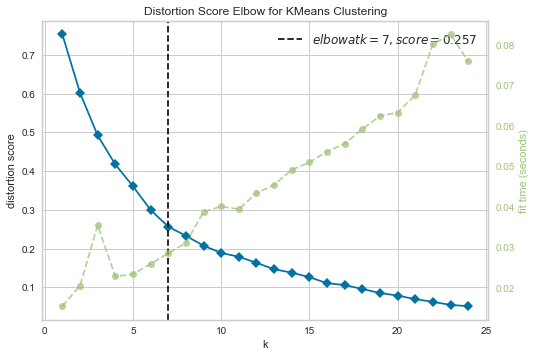

In [221]:
# Plot the graph to undestand the right number of clusters
visualizer = KElbowVisualizer(km, k=K)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [228]:
num_clusters = 7
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, random_state=1021)

# To obtain the clusters do either
# -- kmeans_model.fit(model.docvecs.doctag_syn0)
# -- clusters=kmeans_model.labels_.tolist()
# OR
# -- clusters = kmeans_model.fit_predict(X) 
#
# I personally prefer the second option

clusters = kmeans_model.fit_predict(X) 
# Assign the cluser labels back to the dataframe
data['Doc2Vec cluster'] = clusters

In [229]:
## Have to verify what's happening here, because it's likely I need to replace the keyword vocabulary

printClusters(keywsVoc, num_clusters, kmeans_model.cluster_centers_, 'Doc2Vec cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 air                      0.07798                                                                                                
 alway                    0.0177                                                                                                 

Cluster 0 titles:
 The pedestrian is crossing the zebra.
 The train is running on the tracks.
 The bike is running on the pavement.
 Birds dont fly when is dark
 I really want to go to work, but I am too sick to drive.
 I dont like walking when it is dark
 Playing an instrument like the guitar takes out the stress from my day.


Cluster 1 words:
 Keyword                  Value     
-----------------------------------
 alway                    0.1017                                                                                                 
 bike                     0.07236                                         

# Word2Vec
Couldn't manage to get this complete at the moment. But I don't think it's worth doing considering my corpus is made by documents made by multiple words 